# 프로젝트 1: 생산관리 - OEE & 생산 효율 분석

## 프로젝트 배경

당신은 **한국정밀산업(주)** 스마트팩토리팀의 데이터 분석가입니다.  
공장에는 **3개 라인(A·B·C)**, 총 **12대의 가공설비**가 가동 중이며, **6종의 제품**을 생산합니다.

최근 경영진으로부터 다음과 같은 요청이 내려왔습니다:

> *"우리 공장 설비들의 종합효율(OEE)을 체계적으로 분석해 주세요.  
> 어떤 라인, 어떤 설비에서 로스가 가장 크고,  
> 개선 활동(3월 시작) 이후 실제로 효과가 있었는지 데이터로 보여주세요."*

### 분석 목표
1. **데이터 품질 확인** - 현장 데이터의 결측치·이상치를 파악하고 전처리
2. **OEE 산출** - 가동률 × 성능률 × 양품률을 설비·라인·기간별로 계산
3. **Six Big Losses 분석** - 비가동 유형별 로스를 정량화
4. **개선 효과 검증** - 3월 전/후 OEE 변화를 통계적으로 비교
5. **경영진 보고용 대시보드** - 핵심 KPI를 한눈에 보여주는 시각화

### 데이터 설명

| 파일 | 설명 | 주요 컬럼 |
|------|------|----------|
| `p1_equipment.csv` | 설비 마스터 (13대) | equipment_id, line, equipment_type, rated_capacity_per_hour |
| `p1_product.csv` | 제품 마스터 (6종) | product_code, standard_cycle_time_sec, target_defect_rate_pct |
| `p1_production_log.csv` | 일별 생산 실적 (~3,100건) | production_date, shift, actual_quantity, good_quantity, actual_operating_time_min |
| `p1_downtime_log.csv` | 비가동/로스 기록 (~430건) | downtime_type, duration_min, cause |

### OEE (Overall Equipment Effectiveness) 공식

```
OEE = 가동률(Availability) × 성능률(Performance) × 양품률(Quality)

가동률 = 실제가동시간 / 계획가동시간
성능률 = (실제생산량 × 기준사이클타임) / 실제가동시간
양품률 = 양품수량 / 실제생산량
```

---

## Part 0: 환경 설정 및 데이터 로드

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import warnings
# warnings.filterwarnings('ignore')

# 한글 폰트 설정
sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터 로드
equipment = pd.read_csv('../data/project1/p1_equipment.csv', encoding='utf-8-sig')
product = pd.read_csv('../data/project1/p1_product.csv', encoding='utf-8-sig')
prod_log = pd.read_csv('../data/project1/p1_production_log.csv', encoding='utf-8-sig')
downtime = pd.read_csv('../data/project1/p1_downtime_log.csv', encoding='utf-8-sig')

# 날짜 컬럼 변환
prod_log['production_date'] = pd.to_datetime(prod_log['production_date'])
downtime['date'] = pd.to_datetime(downtime['date'])
downtime['start_time'] = pd.to_datetime(downtime['start_time'])
downtime['end_time'] = pd.to_datetime(downtime['end_time'])

print('데이터 로드 완료!')
print(f'설비: {len(equipment)}건 | 제품: {len(product)}건 | 생산실적: {len(prod_log)}건 | 비가동: {len(downtime)}건')

데이터 로드 완료!
설비: 13건 | 제품: 6건 | 생산실적: 3120건 | 비가동: 427건


---
## Part 1: 데이터 탐색 및 전처리 (25점)

현장에서 수집된 데이터는 **완벽하지 않습니다.**  
센서 오류, 기록 누락, 입력 실수 등으로 결측치와 이상치가 포함되어 있습니다.  
분석 전에 데이터 품질을 반드시 확인하고 전처리해야 합니다.

> **현업 포인트**: 데이터를 신뢰하지 마세요. 항상 먼저 확인하세요.

### 문제 1-1: 4개 데이터프레임 기본 탐색 (5점)

각 데이터프레임의 shape, dtypes, 처음 5행을 확인하세요.  
특히 **생산 실적(prod_log)**의 컬럼별 결측치 수와 비율을 확인하세요.

**확인할 것:**
- 어떤 컬럼에 결측치가 있는가?
- 결측치 비율이 분석에 영향을 줄 수준인가?

In [2]:
print(equipment.info()) # (13, 7)
equipment.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   equipment_id             13 non-null     object
 1   equipment_name           13 non-null     object
 2   line                     13 non-null     object
 3   equipment_type           13 non-null     object
 4   manufacturer             13 non-null     object
 5   install_date             13 non-null     object
 6   rated_capacity_per_hour  13 non-null     int64 
dtypes: int64(1), object(6)
memory usage: 856.0+ bytes
None


,equipment_id,equipment_name,line,equipment_type,manufacturer,install_date,rated_capacity_per_hour
0,EQ-A01,CNC선반-A1,A라인,CNC선반,화낙,2018-03-15,120
1,EQ-A02,CNC선반-A2,A라인,CNC선반,화낙,2018-06-20,120
2,EQ-A03,밀링머신-A3,A라인,밀링머신,DMG모리,2019-01-10,80
3,EQ-A04,드릴프레스-A4,A라인,드릴프레스,브라더,2019-04-05,150
4,EQ-B01,CNC선반-B1,B라인,CNC선반,화낙,2021-07-01,130


In [3]:
print(product.info()) # (6, 6)
product.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   product_code             6 non-null      object 
 1   product_name             6 non-null      object 
 2   standard_cycle_time_sec  6 non-null      int64  
 3   category                 6 non-null      object 
 4   weight_kg                6 non-null      float64
 5   target_defect_rate_pct   6 non-null      float64
dtypes: float64(2), int64(1), object(3)
memory usage: 416.0+ bytes
None


,product_code,product_name,standard_cycle_time_sec,category,weight_kg,target_defect_rate_pct
0,PRD-001,베어링하우징-S,30,하우징,2.5,1.5
1,PRD-002,베어링하우징-M,45,하우징,4.2,2.0
2,PRD-003,샤프트-A,25,샤프트,1.8,1.0
3,PRD-004,샤프트-B,35,샤프트,2.8,2.5
4,PRD-005,기어박스커버,60,커버,5.5,3.0


In [4]:
print(prod_log.info()) # (3120, 13)
print(prod_log.isnull().sum().nlargest(5))
prod_log.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3120 entries, 0 to 3119
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   log_id                     3120 non-null   object        
 1   production_date            3120 non-null   datetime64[ns]
 2   shift                      3120 non-null   object        
 3   equipment_id               3120 non-null   object        
 4   product_code               3120 non-null   object        
 5   planned_quantity           3120 non-null   int64         
 6   actual_quantity            3120 non-null   int64         
 7   good_quantity              3036 non-null   float64       
 8   defect_quantity            3120 non-null   int64         
 9   planned_time_min           3120 non-null   int64         
 10  actual_operating_time_min  3054 non-null   float64       
 11  setup_time_min             3009 non-null   float64       
 12  operat

,log_id,production_date,shift,equipment_id,product_code,planned_quantity,actual_quantity,good_quantity,defect_quantity,planned_time_min,actual_operating_time_min,setup_time_min,operator_id
0,LOG-00001,2024-01-01,주간,EQ-A01,PRD-003,979,753,743.0,10,480,351.9,15.0,OP-004
1,LOG-00002,2024-01-01,주간,EQ-A02,PRD-001,816,690,680.0,10,480,402.9,15.0,OP-009
2,LOG-00003,2024-01-01,주간,EQ-A03,PRD-004,699,426,407.0,19,480,313.3,25.0,OP-008
3,LOG-00004,2024-01-01,주간,EQ-A04,PRD-003,979,745,732.0,13,480,363.1,40.0,OP-004
4,LOG-00005,2024-01-01,주간,EQ-B02,PRD-003,979,954,953.0,1,480,441.3,20.0,OP-018


In [5]:
print(downtime.info()) # (427, 10)
downtime.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 427 entries, 0 to 426
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   downtime_id    427 non-null    object        
 1   date           427 non-null    datetime64[ns]
 2   equipment_id   427 non-null    object        
 3   shift          427 non-null    object        
 4   downtime_type  427 non-null    object        
 5   start_time     427 non-null    datetime64[ns]
 6   end_time       427 non-null    datetime64[ns]
 7   duration_min   422 non-null    float64       
 8   cause          412 non-null    object        
 9   line           427 non-null    object        
dtypes: datetime64[ns](3), float64(1), object(6)
memory usage: 33.5+ KB
None


,downtime_id,date,equipment_id,shift,downtime_type,start_time,end_time,duration_min,cause,line
0,DT-00001,2024-01-01,EQ-A03,야간,소정지,2024-01-01 22:08:00,2024-01-01 22:18:00,10.0,NaN,A라인
1,DT-00002,2024-01-02,EQ-A01,주간,설비고장,2024-01-02 09:24:00,2024-01-02 11:43:00,139.0,스핀들 이상,A라인
2,DT-00003,2024-01-02,EQ-A04,야간,설비고장,2024-01-02 00:45:00,2024-01-02 01:38:00,53.0,NaN,A라인
3,DT-00004,2024-01-02,EQ-A04,야간,소정지,2024-01-02 03:19:00,2024-01-02 03:35:00,16.0,냉각수 부족,A라인
4,DT-00005,2024-01-02,EQ-C02,주간,셋업/조정,2024-01-02 15:36:00,2024-01-02 16:29:00,53.0,지그 교체,C라인


In [6]:
# 분석 결과:
# 1. prod_log와 downtime에 결측치 존재
# 2. prod_log: good_quantity(float64, 84),
#              actual_operating_time_min(float64, 66),
#              setup_time_min(float64, 111)
#    -> 모두 결측치 처리 필요
# 3. downtime: duration_min(float64, 5),
#              cause(object, 15)
#    -> duration_min 결측치 처리 필요

### 문제 1-2: 생산 실적 결측치 처리 (5점)

생산 현장에서 `good_quantity`(양품수량)가 비어있는 건은 **품질 검사가 아직 완료되지 않은 것**입니다.  
이런 경우 현업에서는 보통 `actual_quantity - defect_quantity`로 추정합니다.

`setup_time_min`이 비어있는 건은 **교대 인수인계 시 기록 누락**입니다.  
해당 설비의 평균 셋업 시간으로 대체하세요.

`actual_operating_time_min`이 비어있는 건도 해당 설비의 평균값으로 대체하세요.

**처리 후 결측치가 0인지 확인하세요.**

In [7]:
# good_quantity 결측치 처리
# actual_quantity - defect_quantity
prod_log['good_quantity'] = prod_log['good_quantity'].fillna(prod_log['actual_quantity'] - prod_log['defect_quantity'])
prod_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3120 entries, 0 to 3119
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   log_id                     3120 non-null   object        
 1   production_date            3120 non-null   datetime64[ns]
 2   shift                      3120 non-null   object        
 3   equipment_id               3120 non-null   object        
 4   product_code               3120 non-null   object        
 5   planned_quantity           3120 non-null   int64         
 6   actual_quantity            3120 non-null   int64         
 7   good_quantity              3120 non-null   float64       
 8   defect_quantity            3120 non-null   int64         
 9   planned_time_min           3120 non-null   int64         
 10  actual_operating_time_min  3054 non-null   float64       
 11  setup_time_min             3009 non-null   float64       
 12  operat

In [8]:
# setup_time_min 결측치 처리
# 설비의 평균 셋업 시간
eq_setup_t_mean = prod_log.groupby('equipment_id')['setup_time_min'].transform('mean')
prod_log['setup_time_min'] = prod_log['setup_time_min'].fillna(eq_setup_t_mean)
prod_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3120 entries, 0 to 3119
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   log_id                     3120 non-null   object        
 1   production_date            3120 non-null   datetime64[ns]
 2   shift                      3120 non-null   object        
 3   equipment_id               3120 non-null   object        
 4   product_code               3120 non-null   object        
 5   planned_quantity           3120 non-null   int64         
 6   actual_quantity            3120 non-null   int64         
 7   good_quantity              3120 non-null   float64       
 8   defect_quantity            3120 non-null   int64         
 9   planned_time_min           3120 non-null   int64         
 10  actual_operating_time_min  3054 non-null   float64       
 11  setup_time_min             3120 non-null   float64       
 12  operat

In [9]:
# actual_operating_time_min 결측치 처리
# 설비의 평균값
eq_op_t_mean = prod_log.groupby('equipment_id')['actual_operating_time_min'].transform('mean')
prod_log['actual_operating_time_min'] = prod_log['actual_operating_time_min'].fillna(eq_op_t_mean)
prod_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3120 entries, 0 to 3119
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   log_id                     3120 non-null   object        
 1   production_date            3120 non-null   datetime64[ns]
 2   shift                      3120 non-null   object        
 3   equipment_id               3120 non-null   object        
 4   product_code               3120 non-null   object        
 5   planned_quantity           3120 non-null   int64         
 6   actual_quantity            3120 non-null   int64         
 7   good_quantity              3120 non-null   float64       
 8   defect_quantity            3120 non-null   int64         
 9   planned_time_min           3120 non-null   int64         
 10  actual_operating_time_min  3120 non-null   float64       
 11  setup_time_min             3120 non-null   float64       
 12  operat

### 문제 1-3: 이상치 탐지 (5점)

생산량이 비정상적으로 낮은 건이 있을 수 있습니다 (자재 문제, 긴급 정지 등).  
`actual_quantity` 컬럼에서 **IQR 방법**으로 이상치를 탐지하세요.

1. Q1, Q3, IQR을 계산하세요
2. 하한(Q1 - 1.5×IQR) 미만인 이상치를 찾으세요
3. 이상치가 몇 건인지, 어떤 설비에서 주로 발생하는지 확인하세요
4. 이상치에 `is_outlier` 플래그 컬럼을 추가하세요 (True/False)

> **현업 포인트**: 이상치를 무조건 제거하면 안 됩니다. 원인을 파악하고, 분석 목적에 따라 포함/제외를 결정합니다.

In [10]:
# 1. Q1, Q3, IQR을 계산하세요
actual_qty_Q1 = prod_log['actual_quantity'].quantile(0.25)
actual_qty_Q3 = prod_log['actual_quantity'].quantile(0.75)
actual_qty_IQR = actual_qty_Q3 - actual_qty_Q1
print(f"Q1: {actual_qty_Q1}\nQ3: {actual_qty_Q3}\nIQR: {actual_qty_IQR}")

Q1: 503.0
Q3: 902.0
IQR: 399.0


In [11]:
# 2. 하한(Q1 - 1.5×IQR) 미만인 이상치를 찾으세요
actual_qty_lb = actual_qty_Q1 - 1.5*actual_qty_IQR
prod_log[prod_log['actual_quantity'] < actual_qty_lb]

,log_id,production_date,shift,equipment_id,product_code,planned_quantity,actual_quantity,good_quantity,defect_quantity,planned_time_min,actual_operating_time_min,setup_time_min,operator_id


In [12]:
# 3. 이상치가 몇 건인지, 어떤 설비에서 주로 발생하는지 확인하세요
actual_qty_ub = actual_qty_Q3 + 1.5*actual_qty_IQR
prod_log[prod_log['actual_quantity'] > actual_qty_ub]

,log_id,production_date,shift,equipment_id,product_code,planned_quantity,actual_quantity,good_quantity,defect_quantity,planned_time_min,actual_operating_time_min,setup_time_min,operator_id


In [13]:
# 4. 이상치에 `is_outlier` 플래그 컬럼을 추가하세요 (True/False)
prod_log['is_outlier'] = (prod_log['actual_quantity'] < actual_qty_lb) | (prod_log['actual_quantity'] > actual_qty_ub)
prod_log

,log_id,production_date,shift,equipment_id,product_code,planned_quantity,actual_quantity,good_quantity,defect_quantity,planned_time_min,actual_operating_time_min,setup_time_min,operator_id,is_outlier
0,LOG-00001,2024-01-01,주간,EQ-A01,PRD-003,979,753,743.0,10,480,351.9,15.0,OP-004,False
1,LOG-00002,2024-01-01,주간,EQ-A02,PRD-001,816,690,680.0,10,480,402.9,15.0,OP-009,False
2,LOG-00003,2024-01-01,주간,EQ-A03,PRD-004,699,426,407.0,19,480,313.3,25.0,OP-008,False
3,LOG-00004,2024-01-01,주간,EQ-A04,PRD-003,979,745,732.0,13,480,363.1,40.0,OP-004,False
4,LOG-00005,2024-01-01,주간,EQ-B02,PRD-003,979,954,953.0,1,480,441.3,20.0,OP-018,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3115,LOG-03116,2024-06-29,주간,EQ-B04,PRD-006,1224,1239,1234.0,5,480,428.2,15.0,OP-018,False
3116,LOG-03117,2024-06-29,주간,EQ-C01,PRD-002,544,462,454.0,8,480,390.8,20.0,OP-009,False
3117,LOG-03118,2024-06-29,주간,EQ-C02,PRD-001,816,843,831.0,12,480,450.2,25.0,OP-010,False
3118,LOG-03119,2024-06-29,주간,EQ-C03,PRD-004,699,708,691.0,17,480,440.2,30.0,OP-006,False


### 문제 1-4: 마스터 데이터 결합 (5점)

생산 실적에 **설비 정보**와 **제품 정보**를 결합하세요.

1. `prod_log`에 `equipment` 테이블의 `line`, `equipment_type`, `equipment_name`을 left join
2. 이어서 `product` 테이블의 `product_name`, `standard_cycle_time_sec`, `category`를 left join
3. 결합 후 행 수가 변하지 않았는지 확인하세요
4. 결합된 데이터프레임을 `df`로 저장하세요

In [14]:
# 1. `prod_log`에 `equipment` 테이블의 `line`, `equipment_type`, `equipment_name`을 left join
df = pd.merge(prod_log, equipment[['equipment_id', 'line', 'equipment_type', 'equipment_name']],
                   on='equipment_id', how='left')
df

,log_id,production_date,shift,equipment_id,product_code,planned_quantity,actual_quantity,good_quantity,defect_quantity,planned_time_min,actual_operating_time_min,setup_time_min,operator_id,is_outlier,line,equipment_type,equipment_name
0,LOG-00001,2024-01-01,주간,EQ-A01,PRD-003,979,753,743.0,10,480,351.9,15.0,OP-004,False,A라인,CNC선반,CNC선반-A1
1,LOG-00002,2024-01-01,주간,EQ-A02,PRD-001,816,690,680.0,10,480,402.9,15.0,OP-009,False,A라인,CNC선반,CNC선반-A2
2,LOG-00003,2024-01-01,주간,EQ-A03,PRD-004,699,426,407.0,19,480,313.3,25.0,OP-008,False,A라인,밀링머신,밀링머신-A3
3,LOG-00004,2024-01-01,주간,EQ-A04,PRD-003,979,745,732.0,13,480,363.1,40.0,OP-004,False,A라인,드릴프레스,드릴프레스-A4
4,LOG-00005,2024-01-01,주간,EQ-B02,PRD-003,979,954,953.0,1,480,441.3,20.0,OP-018,False,B라인,CNC선반,CNC선반-B2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3115,LOG-03116,2024-06-29,주간,EQ-B04,PRD-006,1224,1239,1234.0,5,480,428.2,15.0,OP-018,False,B라인,드릴프레스,드릴프레스-B4
3116,LOG-03117,2024-06-29,주간,EQ-C01,PRD-002,544,462,454.0,8,480,390.8,20.0,OP-009,False,C라인,CNC선반,CNC선반-C1
3117,LOG-03118,2024-06-29,주간,EQ-C02,PRD-001,816,843,831.0,12,480,450.2,25.0,OP-010,False,C라인,CNC선반,CNC선반-C2
3118,LOG-03119,2024-06-29,주간,EQ-C03,PRD-004,699,708,691.0,17,480,440.2,30.0,OP-006,False,C라인,밀링머신,밀링머신-C3


In [15]:
# 2. 이어서 `product` 테이블의 `product_name`, `standard_cycle_time_sec`, `category`를 left join
# 4. 결합된 데이터프레임을 `df`로 저장하세요
df = pd.merge(df, product[['product_code', 'product_name', 'standard_cycle_time_sec', 'category']],
         on='product_code', how='left')
df


,log_id,production_date,shift,equipment_id,product_code,planned_quantity,actual_quantity,good_quantity,defect_quantity,planned_time_min,actual_operating_time_min,setup_time_min,operator_id,is_outlier,line,equipment_type,equipment_name,product_name,standard_cycle_time_sec,category
0,LOG-00001,2024-01-01,주간,EQ-A01,PRD-003,979,753,743.0,10,480,351.9,15.0,OP-004,False,A라인,CNC선반,CNC선반-A1,샤프트-A,25,샤프트
1,LOG-00002,2024-01-01,주간,EQ-A02,PRD-001,816,690,680.0,10,480,402.9,15.0,OP-009,False,A라인,CNC선반,CNC선반-A2,베어링하우징-S,30,하우징
2,LOG-00003,2024-01-01,주간,EQ-A03,PRD-004,699,426,407.0,19,480,313.3,25.0,OP-008,False,A라인,밀링머신,밀링머신-A3,샤프트-B,35,샤프트
3,LOG-00004,2024-01-01,주간,EQ-A04,PRD-003,979,745,732.0,13,480,363.1,40.0,OP-004,False,A라인,드릴프레스,드릴프레스-A4,샤프트-A,25,샤프트
4,LOG-00005,2024-01-01,주간,EQ-B02,PRD-003,979,954,953.0,1,480,441.3,20.0,OP-018,False,B라인,CNC선반,CNC선반-B2,샤프트-A,25,샤프트
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3115,LOG-03116,2024-06-29,주간,EQ-B04,PRD-006,1224,1239,1234.0,5,480,428.2,15.0,OP-018,False,B라인,드릴프레스,드릴프레스-B4,플랜지,20,플랜지
3116,LOG-03117,2024-06-29,주간,EQ-C01,PRD-002,544,462,454.0,8,480,390.8,20.0,OP-009,False,C라인,CNC선반,CNC선반-C1,베어링하우징-M,45,하우징
3117,LOG-03118,2024-06-29,주간,EQ-C02,PRD-001,816,843,831.0,12,480,450.2,25.0,OP-010,False,C라인,CNC선반,CNC선반-C2,베어링하우징-S,30,하우징
3118,LOG-03119,2024-06-29,주간,EQ-C03,PRD-004,699,708,691.0,17,480,440.2,30.0,OP-006,False,C라인,밀링머신,밀링머신-C3,샤프트-B,35,샤프트


In [16]:
# 3. 결합 후 행 수가 변하지 않았는지 확인하세요
print(len(prod_log), len(df))

3120 3120


### 문제 1-5: 분석용 파생 컬럼 생성 (5점)

OEE 분석을 위해 다음 파생 컬럼을 만드세요:

1. `month` - 생산월 (1~6)
2. `week` - 주차 (ISO 주차)
3. `weekday` - 요일명 (월요일~토요일)
4. `defect_rate` - 불량률 (%) = defect_quantity / actual_quantity × 100
5. `achievement_rate` - 계획 달성률 (%) = actual_quantity / planned_quantity × 100

각 컬럼의 기본 통계(describe)를 확인하세요.

In [17]:
# 1. `month` - 생산월 (1~6)
df['month'] = df['production_date'].dt.month
df

,log_id,production_date,shift,equipment_id,product_code,planned_quantity,actual_quantity,good_quantity,defect_quantity,planned_time_min,...,setup_time_min,operator_id,is_outlier,line,equipment_type,equipment_name,product_name,standard_cycle_time_sec,category,month
0,LOG-00001,2024-01-01,주간,EQ-A01,PRD-003,979,753,743.0,10,480,...,15.0,OP-004,False,A라인,CNC선반,CNC선반-A1,샤프트-A,25,샤프트,1
1,LOG-00002,2024-01-01,주간,EQ-A02,PRD-001,816,690,680.0,10,480,...,15.0,OP-009,False,A라인,CNC선반,CNC선반-A2,베어링하우징-S,30,하우징,1
2,LOG-00003,2024-01-01,주간,EQ-A03,PRD-004,699,426,407.0,19,480,...,25.0,OP-008,False,A라인,밀링머신,밀링머신-A3,샤프트-B,35,샤프트,1
3,LOG-00004,2024-01-01,주간,EQ-A04,PRD-003,979,745,732.0,13,480,...,40.0,OP-004,False,A라인,드릴프레스,드릴프레스-A4,샤프트-A,25,샤프트,1
4,LOG-00005,2024-01-01,주간,EQ-B02,PRD-003,979,954,953.0,1,480,...,20.0,OP-018,False,B라인,CNC선반,CNC선반-B2,샤프트-A,25,샤프트,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3115,LOG-03116,2024-06-29,주간,EQ-B04,PRD-006,1224,1239,1234.0,5,480,...,15.0,OP-018,False,B라인,드릴프레스,드릴프레스-B4,플랜지,20,플랜지,6
3116,LOG-03117,2024-06-29,주간,EQ-C01,PRD-002,544,462,454.0,8,480,...,20.0,OP-009,False,C라인,CNC선반,CNC선반-C1,베어링하우징-M,45,하우징,6
3117,LOG-03118,2024-06-29,주간,EQ-C02,PRD-001,816,843,831.0,12,480,...,25.0,OP-010,False,C라인,CNC선반,CNC선반-C2,베어링하우징-S,30,하우징,6
3118,LOG-03119,2024-06-29,주간,EQ-C03,PRD-004,699,708,691.0,17,480,...,30.0,OP-006,False,C라인,밀링머신,밀링머신-C3,샤프트-B,35,샤프트,6


In [18]:
# 2. `week` - 주차 (ISO 주차)
df['week'] = df['production_date'].dt.isocalendar().week.astype(int)
df

,log_id,production_date,shift,equipment_id,product_code,planned_quantity,actual_quantity,good_quantity,defect_quantity,planned_time_min,...,operator_id,is_outlier,line,equipment_type,equipment_name,product_name,standard_cycle_time_sec,category,month,week
0,LOG-00001,2024-01-01,주간,EQ-A01,PRD-003,979,753,743.0,10,480,...,OP-004,False,A라인,CNC선반,CNC선반-A1,샤프트-A,25,샤프트,1,1
1,LOG-00002,2024-01-01,주간,EQ-A02,PRD-001,816,690,680.0,10,480,...,OP-009,False,A라인,CNC선반,CNC선반-A2,베어링하우징-S,30,하우징,1,1
2,LOG-00003,2024-01-01,주간,EQ-A03,PRD-004,699,426,407.0,19,480,...,OP-008,False,A라인,밀링머신,밀링머신-A3,샤프트-B,35,샤프트,1,1
3,LOG-00004,2024-01-01,주간,EQ-A04,PRD-003,979,745,732.0,13,480,...,OP-004,False,A라인,드릴프레스,드릴프레스-A4,샤프트-A,25,샤프트,1,1
4,LOG-00005,2024-01-01,주간,EQ-B02,PRD-003,979,954,953.0,1,480,...,OP-018,False,B라인,CNC선반,CNC선반-B2,샤프트-A,25,샤프트,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3115,LOG-03116,2024-06-29,주간,EQ-B04,PRD-006,1224,1239,1234.0,5,480,...,OP-018,False,B라인,드릴프레스,드릴프레스-B4,플랜지,20,플랜지,6,26
3116,LOG-03117,2024-06-29,주간,EQ-C01,PRD-002,544,462,454.0,8,480,...,OP-009,False,C라인,CNC선반,CNC선반-C1,베어링하우징-M,45,하우징,6,26
3117,LOG-03118,2024-06-29,주간,EQ-C02,PRD-001,816,843,831.0,12,480,...,OP-010,False,C라인,CNC선반,CNC선반-C2,베어링하우징-S,30,하우징,6,26
3118,LOG-03119,2024-06-29,주간,EQ-C03,PRD-004,699,708,691.0,17,480,...,OP-006,False,C라인,밀링머신,밀링머신-C3,샤프트-B,35,샤프트,6,26


In [19]:
# 3. `weekday` - 요일명 (월요일~토요일)
df['weekday'] = df['production_date'].dt.strftime('%a요일')
df

,log_id,production_date,shift,equipment_id,product_code,planned_quantity,actual_quantity,good_quantity,defect_quantity,planned_time_min,...,is_outlier,line,equipment_type,equipment_name,product_name,standard_cycle_time_sec,category,month,week,weekday
0,LOG-00001,2024-01-01,주간,EQ-A01,PRD-003,979,753,743.0,10,480,...,False,A라인,CNC선반,CNC선반-A1,샤프트-A,25,샤프트,1,1,Mon요일
1,LOG-00002,2024-01-01,주간,EQ-A02,PRD-001,816,690,680.0,10,480,...,False,A라인,CNC선반,CNC선반-A2,베어링하우징-S,30,하우징,1,1,Mon요일
2,LOG-00003,2024-01-01,주간,EQ-A03,PRD-004,699,426,407.0,19,480,...,False,A라인,밀링머신,밀링머신-A3,샤프트-B,35,샤프트,1,1,Mon요일
3,LOG-00004,2024-01-01,주간,EQ-A04,PRD-003,979,745,732.0,13,480,...,False,A라인,드릴프레스,드릴프레스-A4,샤프트-A,25,샤프트,1,1,Mon요일
4,LOG-00005,2024-01-01,주간,EQ-B02,PRD-003,979,954,953.0,1,480,...,False,B라인,CNC선반,CNC선반-B2,샤프트-A,25,샤프트,1,1,Mon요일
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3115,LOG-03116,2024-06-29,주간,EQ-B04,PRD-006,1224,1239,1234.0,5,480,...,False,B라인,드릴프레스,드릴프레스-B4,플랜지,20,플랜지,6,26,Sat요일
3116,LOG-03117,2024-06-29,주간,EQ-C01,PRD-002,544,462,454.0,8,480,...,False,C라인,CNC선반,CNC선반-C1,베어링하우징-M,45,하우징,6,26,Sat요일
3117,LOG-03118,2024-06-29,주간,EQ-C02,PRD-001,816,843,831.0,12,480,...,False,C라인,CNC선반,CNC선반-C2,베어링하우징-S,30,하우징,6,26,Sat요일
3118,LOG-03119,2024-06-29,주간,EQ-C03,PRD-004,699,708,691.0,17,480,...,False,C라인,밀링머신,밀링머신-C3,샤프트-B,35,샤프트,6,26,Sat요일


In [20]:
# 4. `defect_rate` - 불량률 (%) = defect_quantity / actual_quantity × 100
df['defect_rate'] = df['defect_quantity']/df['actual_quantity']*100
df

,log_id,production_date,shift,equipment_id,product_code,planned_quantity,actual_quantity,good_quantity,defect_quantity,planned_time_min,...,line,equipment_type,equipment_name,product_name,standard_cycle_time_sec,category,month,week,weekday,defect_rate
0,LOG-00001,2024-01-01,주간,EQ-A01,PRD-003,979,753,743.0,10,480,...,A라인,CNC선반,CNC선반-A1,샤프트-A,25,샤프트,1,1,Mon요일,1.328021
1,LOG-00002,2024-01-01,주간,EQ-A02,PRD-001,816,690,680.0,10,480,...,A라인,CNC선반,CNC선반-A2,베어링하우징-S,30,하우징,1,1,Mon요일,1.449275
2,LOG-00003,2024-01-01,주간,EQ-A03,PRD-004,699,426,407.0,19,480,...,A라인,밀링머신,밀링머신-A3,샤프트-B,35,샤프트,1,1,Mon요일,4.460094
3,LOG-00004,2024-01-01,주간,EQ-A04,PRD-003,979,745,732.0,13,480,...,A라인,드릴프레스,드릴프레스-A4,샤프트-A,25,샤프트,1,1,Mon요일,1.744966
4,LOG-00005,2024-01-01,주간,EQ-B02,PRD-003,979,954,953.0,1,480,...,B라인,CNC선반,CNC선반-B2,샤프트-A,25,샤프트,1,1,Mon요일,0.104822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3115,LOG-03116,2024-06-29,주간,EQ-B04,PRD-006,1224,1239,1234.0,5,480,...,B라인,드릴프레스,드릴프레스-B4,플랜지,20,플랜지,6,26,Sat요일,0.403551
3116,LOG-03117,2024-06-29,주간,EQ-C01,PRD-002,544,462,454.0,8,480,...,C라인,CNC선반,CNC선반-C1,베어링하우징-M,45,하우징,6,26,Sat요일,1.731602
3117,LOG-03118,2024-06-29,주간,EQ-C02,PRD-001,816,843,831.0,12,480,...,C라인,CNC선반,CNC선반-C2,베어링하우징-S,30,하우징,6,26,Sat요일,1.423488
3118,LOG-03119,2024-06-29,주간,EQ-C03,PRD-004,699,708,691.0,17,480,...,C라인,밀링머신,밀링머신-C3,샤프트-B,35,샤프트,6,26,Sat요일,2.401130


In [21]:
# 5. `achievement_rate` - 계획 달성률 (%) = actual_quantity / planned_quantity × 100
df['achievement_rate'] = df['actual_quantity']/df['planned_quantity']*100
df

,log_id,production_date,shift,equipment_id,product_code,planned_quantity,actual_quantity,good_quantity,defect_quantity,planned_time_min,...,equipment_type,equipment_name,product_name,standard_cycle_time_sec,category,month,week,weekday,defect_rate,achievement_rate
0,LOG-00001,2024-01-01,주간,EQ-A01,PRD-003,979,753,743.0,10,480,...,CNC선반,CNC선반-A1,샤프트-A,25,샤프트,1,1,Mon요일,1.328021,76.915220
1,LOG-00002,2024-01-01,주간,EQ-A02,PRD-001,816,690,680.0,10,480,...,CNC선반,CNC선반-A2,베어링하우징-S,30,하우징,1,1,Mon요일,1.449275,84.558824
2,LOG-00003,2024-01-01,주간,EQ-A03,PRD-004,699,426,407.0,19,480,...,밀링머신,밀링머신-A3,샤프트-B,35,샤프트,1,1,Mon요일,4.460094,60.944206
3,LOG-00004,2024-01-01,주간,EQ-A04,PRD-003,979,745,732.0,13,480,...,드릴프레스,드릴프레스-A4,샤프트-A,25,샤프트,1,1,Mon요일,1.744966,76.098059
4,LOG-00005,2024-01-01,주간,EQ-B02,PRD-003,979,954,953.0,1,480,...,CNC선반,CNC선반-B2,샤프트-A,25,샤프트,1,1,Mon요일,0.104822,97.446374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3115,LOG-03116,2024-06-29,주간,EQ-B04,PRD-006,1224,1239,1234.0,5,480,...,드릴프레스,드릴프레스-B4,플랜지,20,플랜지,6,26,Sat요일,0.403551,101.225490
3116,LOG-03117,2024-06-29,주간,EQ-C01,PRD-002,544,462,454.0,8,480,...,CNC선반,CNC선반-C1,베어링하우징-M,45,하우징,6,26,Sat요일,1.731602,84.926471
3117,LOG-03118,2024-06-29,주간,EQ-C02,PRD-001,816,843,831.0,12,480,...,CNC선반,CNC선반-C2,베어링하우징-S,30,하우징,6,26,Sat요일,1.423488,103.308824
3118,LOG-03119,2024-06-29,주간,EQ-C03,PRD-004,699,708,691.0,17,480,...,밀링머신,밀링머신-C3,샤프트-B,35,샤프트,6,26,Sat요일,2.401130,101.287554


In [22]:
df.describe()

,production_date,planned_quantity,actual_quantity,good_quantity,defect_quantity,planned_time_min,actual_operating_time_min,setup_time_min,standard_cycle_time_sec,month,week,defect_rate,achievement_rate
count,3120,3120.000000,3120.000000,3120.000000,3120.000000,3120.0,3120.000000,3120.000000,3120.000000,3120.000000,3120.000000,3120.000000,3120.000000
mean,2024-03-30 18:57:13.846153728,802.624038,716.694231,706.153526,10.540705,480.0,395.931930,21.756508,34.256410,3.482372,13.504167,1.717231,88.988063
min,2024-01-01 00:00:00,408.000000,52.000000,49.000000,1.000000,480.0,265.100000,15.000000,20.000000,1.000000,1.000000,0.074683,12.017167
25%,2024-02-15 00:00:00,544.000000,503.000000,493.000000,7.000000,480.0,373.975000,15.000000,25.000000,2.000000,7.000000,0.972628,81.920327
50%,2024-04-01 00:00:00,816.000000,729.000000,718.000000,10.000000,480.0,398.200000,20.000000,30.000000,4.000000,14.000000,1.537280,89.785495
75%,2024-05-15 00:00:00,979.000000,902.000000,892.000000,13.000000,480.0,421.161943,25.000000,45.000000,5.000000,20.000000,2.321322,97.058824
max,2024-06-29 00:00:00,1224.000000,1380.000000,1377.000000,50.000000,480.0,460.200000,40.000000,60.000000,6.000000,26.000000,8.896797,112.768131
std,NaN,252.454517,252.705636,253.058232,4.797230,0.0,35.245915,6.341044,12.590485,1.701802,7.468088,1.019999,12.347651


---
## Part 2: OEE 산출 (25점)

**OEE(Overall Equipment Effectiveness, 설비종합효율)**은 제조업에서 가장 중요한 KPI 중 하나입니다.  
세계적 제조기업들의 OEE 벤치마크:

| 등급 | OEE | 의미 |
|------|-----|------|
| World Class | 85% 이상 | 글로벌 상위 |
| Good | 70~85% | 양호 |
| Average | 55~70% | 개선 필요 |
| Poor | 55% 미만 | 심각한 로스 |

> **왜 OEE인가?** 단순 가동률만 보면 '속도 로스'와 '품질 로스'를 놓칩니다.  
> OEE는 시간·속도·품질 세 관점을 곱해 **진짜 효율**을 보여줍니다.

### 문제 2-1: 건별 OEE 3요소 계산 (10점)

각 생산 실적 건(행)마다 OEE 3요소를 계산하세요.  
이상치(`is_outlier == True`)는 **제외**하고 계산하세요.

```
가동률(availability) = actual_operating_time_min / planned_time_min
성능률(performance) = (actual_quantity × standard_cycle_time_sec / 60) / actual_operating_time_min
양품률(quality)     = good_quantity / actual_quantity
OEE               = availability × performance × quality
```

1. 위 4개 컬럼을 `df`에 추가하세요 (소수점, 0~1 범위)
2. OEE의 기본 통계(describe)를 확인하세요
3. OEE가 1을 초과하는 건이 있는지 확인하고, 있다면 1로 클리핑하세요

> **주의**: 성능률이 1을 초과할 수 있습니다 (기준 사이클타임보다 빠르게 생산한 경우).  
> 현업에서는 보통 1.0으로 제한(clip)합니다.

In [23]:
# 1. 위 4개 컬럼을 `df`에 추가하세요 (소수점, 0~1 범위)
df.loc[df['is_outlier'] == False, 'availability'] = (df['actual_operating_time_min']/df['planned_time_min']).clip(0, 1)
df.loc[df['is_outlier'] == False, 'performance'] = ((df['actual_quantity']*df['standard_cycle_time_sec']/60)/df['actual_operating_time_min']).clip(0, 1)
df.loc[df['is_outlier'] == False, 'quality'] = (df['good_quantity']/df['actual_quantity']).clip(0, 1)
df.loc[df['is_outlier'] == False, 'OEE'] = df['availability']*df['performance']*df['quality']
df

,log_id,production_date,shift,equipment_id,product_code,planned_quantity,actual_quantity,good_quantity,defect_quantity,planned_time_min,...,category,month,week,weekday,defect_rate,achievement_rate,availability,performance,quality,OEE
0,LOG-00001,2024-01-01,주간,EQ-A01,PRD-003,979,753,743.0,10,480,...,샤프트,1,1,Mon요일,1.328021,76.915220,0.733125,0.891589,0.986720,0.644965
1,LOG-00002,2024-01-01,주간,EQ-A02,PRD-001,816,690,680.0,10,480,...,하우징,1,1,Mon요일,1.449275,84.558824,0.839375,0.856292,0.985507,0.708333
2,LOG-00003,2024-01-01,주간,EQ-A03,PRD-004,699,426,407.0,19,480,...,샤프트,1,1,Mon요일,4.460094,60.944206,0.652708,0.793169,0.955399,0.494618
3,LOG-00004,2024-01-01,주간,EQ-A04,PRD-003,979,745,732.0,13,480,...,샤프트,1,1,Mon요일,1.744966,76.098059,0.756458,0.854907,0.982550,0.635417
4,LOG-00005,2024-01-01,주간,EQ-B02,PRD-003,979,954,953.0,1,480,...,샤프트,1,1,Mon요일,0.104822,97.446374,0.919375,0.900748,0.998952,0.827257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3115,LOG-03116,2024-06-29,주간,EQ-B04,PRD-006,1224,1239,1234.0,5,480,...,플랜지,6,26,Sat요일,0.403551,101.225490,0.892083,0.964503,0.995964,0.856944
3116,LOG-03117,2024-06-29,주간,EQ-C01,PRD-002,544,462,454.0,8,480,...,하우징,6,26,Sat요일,1.731602,84.926471,0.814167,0.886643,0.982684,0.709375
3117,LOG-03118,2024-06-29,주간,EQ-C02,PRD-001,816,843,831.0,12,480,...,하우징,6,26,Sat요일,1.423488,103.308824,0.937917,0.936251,0.985765,0.865625
3118,LOG-03119,2024-06-29,주간,EQ-C03,PRD-004,699,708,691.0,17,480,...,샤프트,6,26,Sat요일,2.401130,101.287554,0.917083,0.938210,0.975989,0.839757


In [24]:
# 2. OEE의 기본 통계(describe)를 확인하세요
df['OEE'].describe()

count    3120.000000
mean        0.743627
std         0.105713
min         0.096007
25%         0.682682
50%         0.750868
75%         0.813368
max         0.956250
Name: OEE, dtype: float64

In [25]:
# 3. OEE가 1을 초과하는 건이 있는지 확인하고, 있다면 1로 클리핑하세요
df['OEE'] = df['OEE'].clip(0, 1)
df

,log_id,production_date,shift,equipment_id,product_code,planned_quantity,actual_quantity,good_quantity,defect_quantity,planned_time_min,...,category,month,week,weekday,defect_rate,achievement_rate,availability,performance,quality,OEE
0,LOG-00001,2024-01-01,주간,EQ-A01,PRD-003,979,753,743.0,10,480,...,샤프트,1,1,Mon요일,1.328021,76.915220,0.733125,0.891589,0.986720,0.644965
1,LOG-00002,2024-01-01,주간,EQ-A02,PRD-001,816,690,680.0,10,480,...,하우징,1,1,Mon요일,1.449275,84.558824,0.839375,0.856292,0.985507,0.708333
2,LOG-00003,2024-01-01,주간,EQ-A03,PRD-004,699,426,407.0,19,480,...,샤프트,1,1,Mon요일,4.460094,60.944206,0.652708,0.793169,0.955399,0.494618
3,LOG-00004,2024-01-01,주간,EQ-A04,PRD-003,979,745,732.0,13,480,...,샤프트,1,1,Mon요일,1.744966,76.098059,0.756458,0.854907,0.982550,0.635417
4,LOG-00005,2024-01-01,주간,EQ-B02,PRD-003,979,954,953.0,1,480,...,샤프트,1,1,Mon요일,0.104822,97.446374,0.919375,0.900748,0.998952,0.827257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3115,LOG-03116,2024-06-29,주간,EQ-B04,PRD-006,1224,1239,1234.0,5,480,...,플랜지,6,26,Sat요일,0.403551,101.225490,0.892083,0.964503,0.995964,0.856944
3116,LOG-03117,2024-06-29,주간,EQ-C01,PRD-002,544,462,454.0,8,480,...,하우징,6,26,Sat요일,1.731602,84.926471,0.814167,0.886643,0.982684,0.709375
3117,LOG-03118,2024-06-29,주간,EQ-C02,PRD-001,816,843,831.0,12,480,...,하우징,6,26,Sat요일,1.423488,103.308824,0.937917,0.936251,0.985765,0.865625
3118,LOG-03119,2024-06-29,주간,EQ-C03,PRD-004,699,708,691.0,17,480,...,샤프트,6,26,Sat요일,2.401130,101.287554,0.917083,0.938210,0.975989,0.839757


### 문제 2-2: 설비별 OEE 집계 (5점)

설비별(equipment_id) 평균 OEE와 3요소를 집계하세요.

1. 설비별 평균 `availability`, `performance`, `quality`, `oee`를 계산
2. OEE 기준 내림차순 정렬
3. 결과에 `equipment_name`과 `line`을 포함
4. OEE가 가장 낮은 설비 3대는 어디인가?
5. 어떤 요소(가동률/성능률/양품률)가 OEE를 끌어내리고 있는가?

In [26]:
# 1. 설비별 평균 `availability`, `performance`, `quality`, `oee`를 계산
eq_params = df.groupby('equipment_id')[['availability', 'performance', 'quality', 'OEE']].mean()
eq_params

,availability,performance,quality,OEE
equipment_id,,,,
EQ-A01,0.787264,0.879337,0.980208,0.678933
EQ-A02,0.783246,0.884348,0.980889,0.679595
EQ-A03,0.698127,0.878418,0.964572,0.592378
EQ-A04,0.789697,0.886964,0.987322,0.691929
EQ-B01,0.876626,0.949095,0.988051,0.822168
EQ-B02,0.877976,0.952091,0.989244,0.827126
EQ-B03,0.877421,0.952771,0.979067,0.818694
EQ-B04,0.883420,0.938313,0.992040,0.822381
EQ-C01,0.831759,0.916762,0.985037,0.751091


In [27]:
# 2. OEE 기준 내림차순 정렬
eq_params = eq_params.sort_values('OEE', ascending=False)
eq_params

,availability,performance,quality,OEE
equipment_id,,,,
EQ-B02,0.877976,0.952091,0.989244,0.827126
EQ-B04,0.883420,0.938313,0.992040,0.822381
EQ-B01,0.876626,0.949095,0.988051,0.822168
EQ-B03,0.877421,0.952771,0.979067,0.818694
EQ-C02,0.836890,0.912994,0.985817,0.753474
EQ-C01,0.831759,0.916762,0.985037,0.751091
EQ-C04,0.831600,0.912093,0.989775,0.750806
EQ-C03,0.825974,0.917282,0.972363,0.736975
EQ-A04,0.789697,0.886964,0.987322,0.691929


In [28]:
# 3. 결과에 `equipment_name`과 `line`을 포함
eq_params = pd.merge(eq_params, equipment[['equipment_id', 'equipment_name', 'line']], on='equipment_id', how='left')
eq_params

,equipment_id,availability,performance,quality,OEE,equipment_name,line
0,EQ-B02,0.877976,0.952091,0.989244,0.827126,CNC선반-B2,B라인
1,EQ-B04,0.883420,0.938313,0.992040,0.822381,드릴프레스-B4,B라인
2,EQ-B01,0.876626,0.949095,0.988051,0.822168,CNC선반-B1,B라인
3,EQ-B03,0.877421,0.952771,0.979067,0.818694,밀링머신-B3,B라인
4,EQ-C02,0.836890,0.912994,0.985817,0.753474,CNC선반-C2,C라인
5,EQ-C01,0.831759,0.916762,0.985037,0.751091,CNC선반-C1,C라인
6,EQ-C04,0.831600,0.912093,0.989775,0.750806,드릴프레스-C4,C라인
7,EQ-C03,0.825974,0.917282,0.972363,0.736975,밀링머신-C3,C라인
8,EQ-A04,0.789697,0.886964,0.987322,0.691929,드릴프레스-A4,A라인
9,EQ-A02,0.783246,0.884348,0.980889,0.679595,CNC선반-A2,A라인


In [29]:
# 4. OEE가 가장 낮은 설비 3대는 어디인가?
eq_params.nsmallest(3, 'OEE')

,equipment_id,availability,performance,quality,OEE,equipment_name,line
11,EQ-A03,0.698127,0.878418,0.964572,0.592378,밀링머신-A3,A라인
10,EQ-A01,0.787264,0.879337,0.980208,0.678933,CNC선반-A1,A라인
9,EQ-A02,0.783246,0.884348,0.980889,0.679595,CNC선반-A2,A라인


In [30]:
# 5. 어떤 요소(가동률/성능률/양품률)가 OEE를 끌어내리고 있는가?
eq_params.nsmallest(3, 'OEE')[['availability', 'performance', 'quality']].idxmin(axis=1)

11    availability
10    availability
9     availability
dtype: object

### 문제 2-3: 라인별·월별 OEE 추이 (10점)

경영진은 **3월에 시작한 설비 개선 활동**의 효과를 확인하고 싶어합니다.

1. 라인별(A/B/C) + 월별 평균 OEE를 피벗 테이블로 만드세요  
   - index='line', columns='month', values='oee'
2. 해당 피벗 테이블을 **히트맵**으로 시각화하세요
   - `annot=True, fmt='.1%'` (퍼센트 포맷)
   - `cmap='RdYlGn'` (빨강→노랑→녹색)
3. 전체 월별 OEE 추이를 **라인 차트**로 그리세요
   - 라인별 색상 구분
   - 3월에 세로 점선 추가 (`axvline`)하여 '개선 활동 시작' 표시
4. 개선 전(1~3월)과 개선 후(4~6월) 평균 OEE를 비교하는 표를 출력하세요

In [31]:
# 1. 라인별(A/B/C) + 월별 평균 OEE를 피벗 테이블로 만드세요  
#    - index='line', columns='month', values='oee'
line_month_pivot = pd.pivot_table(data=df, index='line', columns='month', values='OEE', aggfunc='mean')
line_month_pivot

month,1,2,3,4,5,6
line,,,,,,
A라인,0.632957,0.642248,0.642356,0.681291,0.682239,0.681329
B라인,0.801524,0.803744,0.802446,0.836706,0.847307,0.843809
C라인,0.727967,0.729795,0.730831,0.768353,0.758238,0.773865


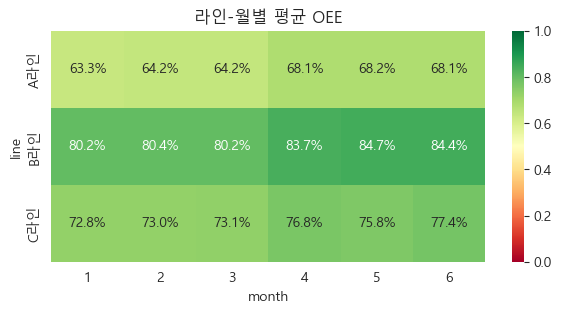

In [32]:
# 2. 해당 피벗 테이블을 **히트맵**으로 시각화하세요
#    - `annot=True, fmt='.1%'` (퍼센트 포맷)
#    - `cmap='RdYlGn'` (빨강→노랑→녹색)
plt.figure(figsize=(7, 3))
sns.heatmap(data=line_month_pivot, annot=True, fmt='.1%', cmap='RdYlGn', vmin=0, vmax=1)

plt.title('라인-월별 평균 OEE')

plt.show()

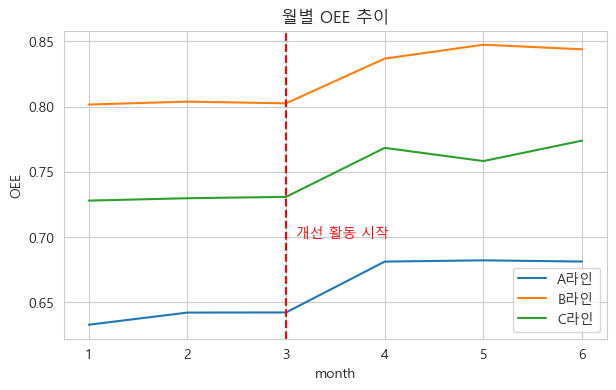

,log_id,production_date,shift,equipment_id,product_code,planned_quantity,actual_quantity,good_quantity,defect_quantity,planned_time_min,...,category,month,week,weekday,defect_rate,achievement_rate,availability,performance,quality,OEE
0,LOG-00001,2024-01-01,주간,EQ-A01,PRD-003,979,753,743.0,10,480,...,샤프트,1,1,Mon요일,1.328021,76.915220,0.733125,0.891589,0.986720,0.644965
1,LOG-00002,2024-01-01,주간,EQ-A02,PRD-001,816,690,680.0,10,480,...,하우징,1,1,Mon요일,1.449275,84.558824,0.839375,0.856292,0.985507,0.708333
2,LOG-00003,2024-01-01,주간,EQ-A03,PRD-004,699,426,407.0,19,480,...,샤프트,1,1,Mon요일,4.460094,60.944206,0.652708,0.793169,0.955399,0.494618
3,LOG-00004,2024-01-01,주간,EQ-A04,PRD-003,979,745,732.0,13,480,...,샤프트,1,1,Mon요일,1.744966,76.098059,0.756458,0.854907,0.982550,0.635417
4,LOG-00005,2024-01-01,주간,EQ-B02,PRD-003,979,954,953.0,1,480,...,샤프트,1,1,Mon요일,0.104822,97.446374,0.919375,0.900748,0.998952,0.827257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3115,LOG-03116,2024-06-29,주간,EQ-B04,PRD-006,1224,1239,1234.0,5,480,...,플랜지,6,26,Sat요일,0.403551,101.225490,0.892083,0.964503,0.995964,0.856944
3116,LOG-03117,2024-06-29,주간,EQ-C01,PRD-002,544,462,454.0,8,480,...,하우징,6,26,Sat요일,1.731602,84.926471,0.814167,0.886643,0.982684,0.709375
3117,LOG-03118,2024-06-29,주간,EQ-C02,PRD-001,816,843,831.0,12,480,...,하우징,6,26,Sat요일,1.423488,103.308824,0.937917,0.936251,0.985765,0.865625
3118,LOG-03119,2024-06-29,주간,EQ-C03,PRD-004,699,708,691.0,17,480,...,샤프트,6,26,Sat요일,2.401130,101.287554,0.917083,0.938210,0.975989,0.839757


In [33]:
# 3. 전체 월별 OEE 추이를 **라인 차트**로 그리세요
#    - 라인별 색상 구분
#    - 3월에 세로 점선 추가 (`axvline`)하여 '개선 활동 시작' 표시
plt.figure(figsize=(7, 4))
sns.lineplot(data=df, x='month', y='OEE', hue='line', errorbar=None)

plt.axvline(x=3, linestyle='--', color='red')
plt.text(x=3.1, y=0.7, s='개선 활동 시작', color='red')

plt.title('월별 OEE 추이')
plt.legend(loc='lower right')

plt.show()
df

In [34]:
# 4. 개선 전(1~3월)과 개선 후(4~6월) 평균 OEE를 비교하는 표를 출력하세요
df.groupby(np.where(df['month'] <= 3, '개선 전(1~3월)', '개선 후(4~6월)'))['OEE'].mean()

개선 전(1~3월)    0.723691
개선 후(4~6월)    0.763437
Name: OEE, dtype: float64

---
## Part 3: 심화 분석 (20점)

OEE 숫자만으로는 부족합니다.  
경영진과 현장 관리자가 **구체적인 액션**을 취하려면,  
교대조·제품·설비 유형별로 **어디서, 왜** 로스가 발생하는지 알아야 합니다.

### 문제 3-1: 교대조별 OEE 비교 (5점)

야간 근무는 주간보다 품질이 떨어진다는 현장의 목소리가 있습니다.  
데이터로 확인해 보세요.

1. 교대조별(주간/야간) OEE 3요소 + OEE 평균을 비교표로 출력
2. **박스플롯**으로 교대조별 OEE 분포를 비교하세요
   - 같은 Figure에 OEE, 가동률, 성능률, 양품률 4개 subplot (2×2)
3. 주간 vs 야간 차이가 통계적으로 유의한지 **t-test**를 수행하세요
   - `from scipy import stats`
   - p-value < 0.05이면 유의한 차이

In [35]:
# 1. 교대조별(주간/야간) OEE 3요소 + OEE 평균을 비교표로 출력
shift_params = df.groupby('shift')[['availability', 'performance', 'quality', 'OEE']].mean()
shift_params

,availability,performance,quality,OEE
shift,,,,
야간,0.815731,0.914262,0.981417,0.734009
주간,0.832443,0.915625,0.984000,0.751620


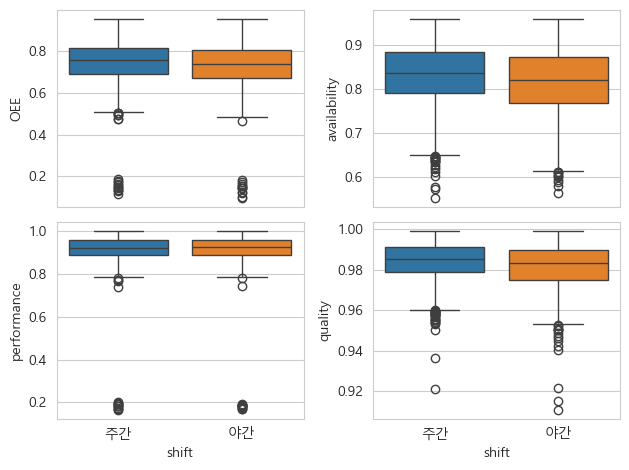

In [36]:
# 2. **박스플롯**으로 교대조별 OEE 분포를 비교하세요
#    - 같은 Figure에 OEE, 가동률, 성능률, 양품률 4개 subplot (2×2)
params =['OEE', 'availability', 'performance', 'quality']
fig, axes = plt.subplots(2, 2, sharex=True)

for idx, (ax, param) in enumerate(zip(axes.flatten(), params)):
    sns.boxplot(data=df, x='shift', y=param, hue='shift', ax=ax)

plt.tight_layout()
plt.show()

In [37]:
# 3. 주간 vs 야간 차이가 통계적으로 유의한지 **t-test**를 수행하세요
#    - `from scipy import stats`
#    - p-value < 0.05이면 유의한 차이
from scipy import stats

params =['OEE', 'availability', 'performance', 'quality']

for param in params:
    day_param = df[df['shift'] == '주간'][param]
    night_param = df[df['shift'] == '야간'][param]
    t_stat, p_value = stats.ttest_ind(day_param, night_param)
    print(f"[{param}] t-test 결과")
    print(f"t-statistic: {t_stat:.4f}")
    print(f"p-value: {p_value:.4f} {'< 0.05, 유의한 차이' if p_value < 0.05 else ''}\n")


[OEE] t-test 결과
t-statistic: 4.6483
p-value: 0.0000 < 0.05, 유의한 차이

[availability] t-test 결과
t-statistic: 6.3692
p-value: 0.0000 < 0.05, 유의한 차이

[performance] t-test 결과
t-statistic: 0.4731
p-value: 0.6362 

[quality] t-test 결과
t-statistic: 7.0957
p-value: 0.0000 < 0.05, 유의한 차이



### 문제 3-2: 설비-제품 매트릭스 분석 (5점)

모든 설비가 모든 제품을 동일하게 잘 만드는 것은 아닙니다.  
**어떤 설비에서 어떤 제품을 만들 때 OEE가 높은지** 매트릭스로 분석하세요.

1. `equipment_id`(행) × `product_code`(열)의 평균 OEE 피벗 테이블
2. **히트맵**으로 시각화 (annot=True, fmt='.1%', cmap='YlGnBu')
3. 가장 OEE가 높은 설비-제품 조합 Top 5, 가장 낮은 조합 Bottom 5를 출력하세요

In [38]:
# 1. `equipment_id`(행) × `product_code`(열)의 평균 OEE 피벗 테이블
eq_prod_pivot = pd.pivot_table(data=df, index='equipment_id', columns='product_code', values='OEE', aggfunc='mean')
eq_prod_pivot

product_code,PRD-001,PRD-002,PRD-003,PRD-004,PRD-005,PRD-006
equipment_id,,,,,,
EQ-A01,0.676840,0.669454,0.692236,NaN,NaN,NaN
EQ-A02,0.687839,0.668005,0.683059,NaN,NaN,NaN
EQ-A03,NaN,NaN,NaN,0.591623,0.593157,NaN
EQ-A04,NaN,NaN,0.695896,NaN,NaN,0.687869
EQ-B01,0.831238,0.809266,0.826032,NaN,NaN,NaN
EQ-B02,0.829666,0.829925,0.821841,NaN,NaN,NaN
EQ-B03,NaN,NaN,NaN,0.826987,0.810594,NaN
EQ-B04,NaN,NaN,0.821055,NaN,NaN,0.823601
EQ-C01,0.754623,0.753049,0.744858,NaN,NaN,NaN


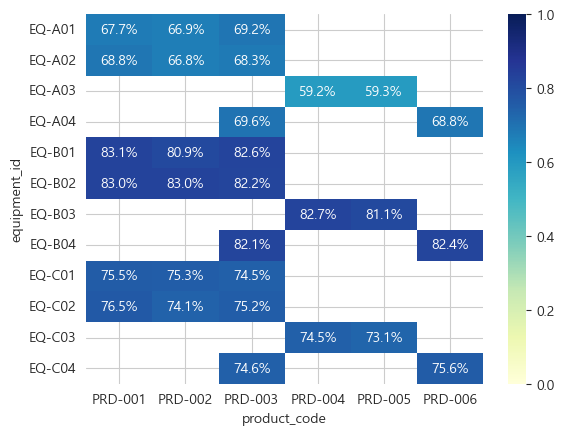

In [39]:
# 2. **히트맵**으로 시각화 (annot=True, fmt='.1%', cmap='YlGnBu')
sns.heatmap(data=eq_prod_pivot, vmin=0, vmax=1, annot=True, fmt='.1%', cmap='YlGnBu')
plt.show()

In [40]:
# 3. 가장 OEE가 높은 설비-제품 조합 Top 5, 가장 낮은 조합 Bottom 5를 출력하세요
print(eq_prod_pivot.unstack().nlargest(5))
print(eq_prod_pivot.unstack().nsmallest(5))

product_code  equipment_id
PRD-001       EQ-B01          0.831238
PRD-002       EQ-B02          0.829925
PRD-001       EQ-B02          0.829666
PRD-004       EQ-B03          0.826987
PRD-003       EQ-B01          0.826032
dtype: float64
product_code  equipment_id
PRD-004       EQ-A03          0.591623
PRD-005       EQ-A03          0.593157
PRD-002       EQ-A02          0.668005
              EQ-A01          0.669454
PRD-001       EQ-A01          0.676840
dtype: float64


### 문제 3-3: 요일별 생산성 패턴 분석 (5점)

월요일 아침에는 설비 워밍업이 필요하고, 금요일 오후에는 피로도가 높다는 가설이 있습니다.

1. 요일별 평균 OEE와 불량률을 집계하세요 (월~토)
2. **이중 y축 차트**로 시각화하세요
   - 왼쪽 y축: 평균 OEE (bar 차트)
   - 오른쪽 y축: 평균 불량률 (line 차트, 빨간색)
3. 어떤 요일에 생산성이 가장 좋고, 가장 나쁜가?

In [41]:
# 1. 요일별 평균 OEE와 불량률을 집계하세요 (월~토)
weekday_params = df.groupby('weekday', observed=True)[['OEE', 'defect_rate']].mean().reindex(['월요일', '화요일', '수요일', '목요일', '금요일', '토요일'])
weekday_params

,OEE,defect_rate
weekday,,
월요일,NaN,NaN
화요일,NaN,NaN
수요일,NaN,NaN
목요일,NaN,NaN
금요일,NaN,NaN
토요일,NaN,NaN


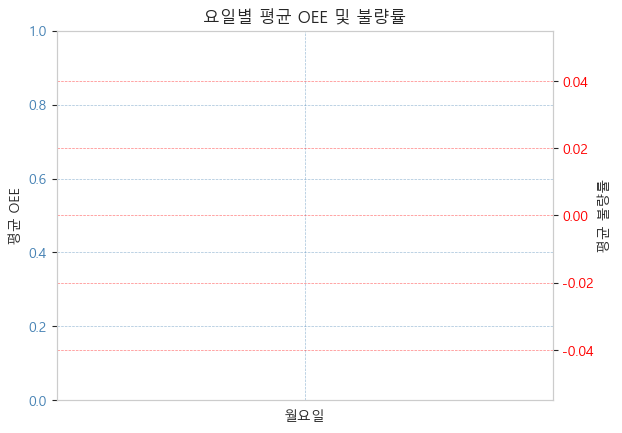

In [42]:
# 2. **이중 y축 차트**로 시각화하세요
#    - 왼쪽 y축: 평균 OEE (bar 차트)
#    - 오른쪽 y축: 평균 불량률 (line 차트, 빨간색)
fig, ax1 = plt.subplots()

ax1.bar(weekday_params.index, weekday_params['OEE'], label='평균 OEE', color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')
ax1.grid(True, color='steelblue', linestyle='--', linewidth=0.5, alpha=0.5)
ax1.set_ylabel('평균 OEE')
ax1.set_ylim(0, 1)

ax2 = ax1.twinx()
ax2.plot(weekday_params['defect_rate'], label='평균 불량률', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.grid(True, color='red', linestyle='--', linewidth=0.5, alpha=0.5)
ax2.set_ylabel('평균 불량률')

plt.title('요일별 평균 OEE 및 불량률')
plt.xlabel('요일')

plt.show()

In [43]:
# 3. 어떤 요일에 생산성이 가장 좋고, 가장 나쁜가?
print(f"[OEE] min: {weekday_params['OEE'].idxmin()}, max: {weekday_params['OEE'].idxmax()}")
print(f"[불량률] min: {weekday_params['defect_rate'].idxmin()}, max: {weekday_params['defect_rate'].idxmax()}")

[OEE] min: nan, max: nan
[불량률] min: nan, max: nan


C:\Users\rapa\AppData\Local\Temp\ipykernel_15852\1269015393.py:2: FutureWarning: The behavior of Series.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  print(f"[OEE] min: {weekday_params['OEE'].idxmin()}, max: {weekday_params['OEE'].idxmax()}")
C:\Users\rapa\AppData\Local\Temp\ipykernel_15852\1269015393.py:2: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  print(f"[OEE] min: {weekday_params['OEE'].idxmin()}, max: {weekday_params['OEE'].idxmax()}")
C:\Users\rapa\AppData\Local\Temp\ipykernel_15852\1269015393.py:3: FutureWarning: The behavior of Series.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  print(f"[불량률] min: {weekday_params['defect_rate'].idxmin()}, max: {weekday_params['defect_rate'].idxmax()}")
C:\Users\rapa\AppData\Local\Temp\ipy

### 문제 3-4: 계획 달성률 vs 불량률 관계 분석 (5점)

"무리하게 생산량을 맞추면 불량이 늘어난다"는 현장의 우려가 있습니다.

1. `achievement_rate`(계획달성률)와 `defect_rate`(불량률)의 **산점도**를 그리세요
   - 라인별 색상 구분 (hue='line')
   - 추세선 포함 (sns.regplot 또는 sns.lmplot)
2. 두 변수의 **상관계수**를 라인별로 계산하세요
3. 달성률 100% 이상인 그룹과 미만인 그룹의 평균 불량률을 비교하세요

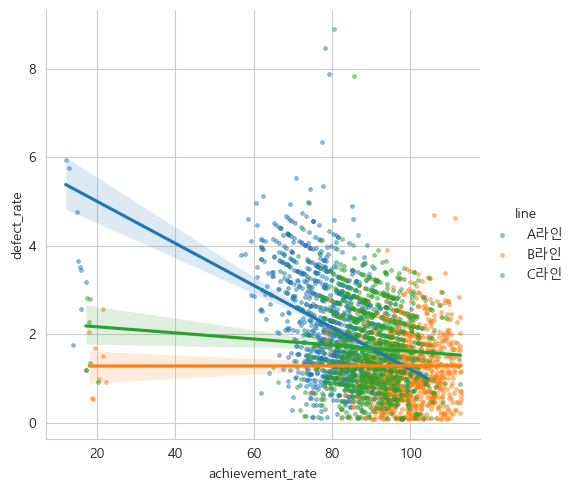

In [44]:
# 1. `achievement_rate`(계획달성률)와 `defect_rate`(불량률)의 **산점도**를 그리세요
#    - 라인별 색상 구분 (hue='line')
#    - 추세선 포함 (sns.regplot 또는 sns.lmplot)
sns.lmplot(data=df, x='achievement_rate', y='defect_rate', hue='line',
           scatter_kws={'s': 8, 'alpha': 0.5, 'linewidths': 0.5})

plt.show()

In [45]:
# 2. 두 변수의 **상관계수**를 라인별로 계산하세요
df.groupby('line')[['achievement_rate', 'defect_rate']].corr()

achievement_rate  defect_rate
line                                                
A라인  achievement_rate          1.000000    -0.417206
     defect_rate              -0.417206     1.000000
B라인  achievement_rate          1.000000     0.000830
     defect_rate               0.000830     1.000000
C라인  achievement_rate          1.000000    -0.070206
     defect_rate              -0.070206     1.000000

In [46]:
# 3. 달성률 100% 이상인 그룹과 미만인 그룹의 평균 불량률을 비교하세요
for line in df.groupby('line'):
    print(f"[{line[0]}]")
    print(f"평균 불량률(달성률 100% 이상): {line[1].loc[df['achievement_rate'] >= 100, 'defect_rate'].mean().round(2)}")
    print(f"평균 불량률(달성률 100% 미만): {line[1].loc[df['achievement_rate'] < 100, 'defect_rate'].mean().round(2)}\n")


[A라인]
평균 불량률(달성률 100% 이상): 1.71
평균 불량률(달성률 100% 미만): 2.18

[B라인]
평균 불량률(달성률 100% 이상): 1.3
평균 불량률(달성률 100% 미만): 1.27

[C라인]
평균 불량률(달성률 100% 이상): 1.63
평균 불량률(달성률 100% 미만): 1.69



---
## Part 4: Six Big Losses 분석 (15점)

TPM(Total Productive Maintenance)에서는 설비 효율을 떨어뜨리는 원인을  
**6대 로스(Six Big Losses)**로 분류합니다:

| 분류 | 로스 유형 | OEE 영향 |
|------|----------|----------|
| 정지 로스 | ① 설비고장, ② 셋업/조정 | 가동률 ↓ |
| 속도 로스 | ③ 소정지, ④ 속도저하 | 성능률 ↓ |
| 불량 로스 | ⑤ 초기불량, ⑥ 공정불량 | 양품률 ↓ |

비가동 데이터(`downtime`)를 활용하여 로스를 분석합니다.

### 문제 4-1: 비가동 유형별 분석 (5점)

1. `downtime` 데이터의 결측치를 처리하세요
   - `duration_min` 결측: 같은 `downtime_type`의 평균값으로 대체
   - `cause` 결측: '원인미상'으로 대체
2. 비가동 유형별 **건수**, **총 시간(분)**, **평균 시간(분)**을 집계하세요
3. **파레토 차트**를 그리세요
   - 막대: 유형별 총 비가동 시간 (내림차순)
   - 선: 누적 비율(%)

In [47]:
# 1. `downtime` 데이터의 결측치를 처리하세요
#    - `duration_min` 결측: 같은 `downtime_type`의 평균값으로 대체
#    - `cause` 결측: '원인미상'으로 대체
dttype_dur_mean = downtime.groupby('downtime_type')['duration_min'].transform('mean')
downtime['duration_min'] = downtime['duration_min'].fillna(dttype_dur_mean)
downtime['cause'] = downtime['cause'].fillna('원인미상')
downtime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 427 entries, 0 to 426
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   downtime_id    427 non-null    object        
 1   date           427 non-null    datetime64[ns]
 2   equipment_id   427 non-null    object        
 3   shift          427 non-null    object        
 4   downtime_type  427 non-null    object        
 5   start_time     427 non-null    datetime64[ns]
 6   end_time       427 non-null    datetime64[ns]
 7   duration_min   427 non-null    float64       
 8   cause          427 non-null    object        
 9   line           427 non-null    object        
dtypes: datetime64[ns](3), float64(1), object(6)
memory usage: 33.5+ KB


In [48]:
# 2. 비가동 유형별 **건수**, **총 시간(분)**, **평균 시간(분)**을 집계하세요
dttype_summary = downtime.groupby('downtime_type').agg({'downtime_id':'count',
                                                        'duration_min':['sum', 'mean']})
dttype_summary.columns = ['건수', '총 시간(분)', '평균 시간(분)']
dttype_summary = dttype_summary.sort_values('총 시간(분)', ascending=False)
dttype_summary

,건수,총 시간(분),평균 시간(분)
downtime_type,,,
설비고장,115,15182.017544,132.017544
속도저하,69,4906.102941,71.102941
계획정지,47,3887.717391,82.717391
셋업/조정,74,2726.000000,36.837838
초기불량,38,1033.388889,27.194444
소정지,84,1030.000000,12.261905


In [49]:
dttype_summary['총 시간 비율'] = (dttype_summary['총 시간(분)']/dttype_summary['총 시간(분)'].sum()*100).round(2)
dttype_summary

,건수,총 시간(분),평균 시간(분),총 시간 비율
downtime_type,,,,
설비고장,115,15182.017544,132.017544,52.78
속도저하,69,4906.102941,71.102941,17.06
계획정지,47,3887.717391,82.717391,13.52
셋업/조정,74,2726.000000,36.837838,9.48
초기불량,38,1033.388889,27.194444,3.59
소정지,84,1030.000000,12.261905,3.58


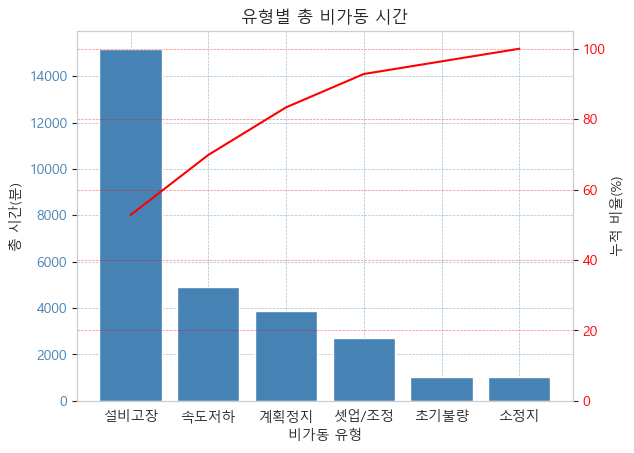

In [50]:
# 3. **파레토 차트**를 그리세요
#    - 막대: 유형별 총 비가동 시간 (내림차순)
#    - 선: 누적 비율(%)
fig, ax1 = plt.subplots()

ax1.bar(dttype_summary.index, dttype_summary['총 시간(분)'], label='총 시간(분)', color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')
ax1.grid(True, color='steelblue', linestyle='--', linewidth=0.5, alpha=0.5)
ax1.set_ylabel('총 시간(분)')
ax1.set_xlabel('비가동 유형')

ax2 = ax1.twinx()
ax2.plot(dttype_summary['총 시간 비율'].cumsum(), label='누적 비율(%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.grid(True, color='red', linestyle='--', linewidth=0.5, alpha=0.5)
ax2.set_ylabel('누적 비율(%)')
ax2.set_ylim(0, 105)

plt.title('유형별 총 비가동 시간')

plt.show()

### 문제 4-2: 설비별 비가동 패턴 분석 (5점)

어떤 설비에서 어떤 유형의 로스가 집중되는지 파악합니다.

1. `equipment_id`(행) × `downtime_type`(열)의 총 비가동 시간 피벗 테이블
2. **스택 바 차트**로 시각화하세요
   - 설비별 누적 막대그래프
   - 각 유형별 색상 구분
3. 비가동 시간이 가장 긴 설비 Top 3는? 주로 어떤 유형인가?
4. 비가동 기록이 없는 설비가 있는지 확인하세요 (equipment 테이블과 left join)

In [51]:
# 1. `equipment_id`(행) × `downtime_type`(열)의 총 비가동 시간 피벗 테이블
eq_dttype_pivot = pd.pivot_table(data=downtime, index='equipment_id', columns='downtime_type', values='duration_min', aggfunc='sum')
eq_dttype_pivot['합계'] = eq_dttype_pivot.sum(axis=1)
eq_dttype_pivot = eq_dttype_pivot.sort_values('합계', ascending=False)
eq_dttype_pivot

downtime_type,계획정지,설비고장,셋업/조정,소정지,속도저하,초기불량,합계
equipment_id,,,,,,,
EQ-A03,560.000000,2973.000000,624.0,201.0,604.102941,95.194444,5057.297386
EQ-A01,643.000000,1809.000000,321.0,124.0,528.000000,169.000000,3594.000000
EQ-A02,553.000000,1627.000000,233.0,107.0,686.000000,123.194444,3329.194444
EQ-A04,341.000000,1761.000000,349.0,199.0,279.000000,105.000000,3034.000000
EQ-C03,409.000000,1273.000000,162.0,69.0,539.000000,95.000000,2547.000000
EQ-C01,232.000000,747.017544,67.0,76.0,851.000000,80.000000,2053.017544
EQ-C02,56.000000,1148.000000,334.0,97.0,227.000000,43.000000,1905.000000
EQ-B03,179.000000,1019.000000,193.0,18.0,122.000000,58.000000,1589.000000
EQ-C04,423.000000,391.000000,146.0,54.0,440.000000,100.000000,1554.000000


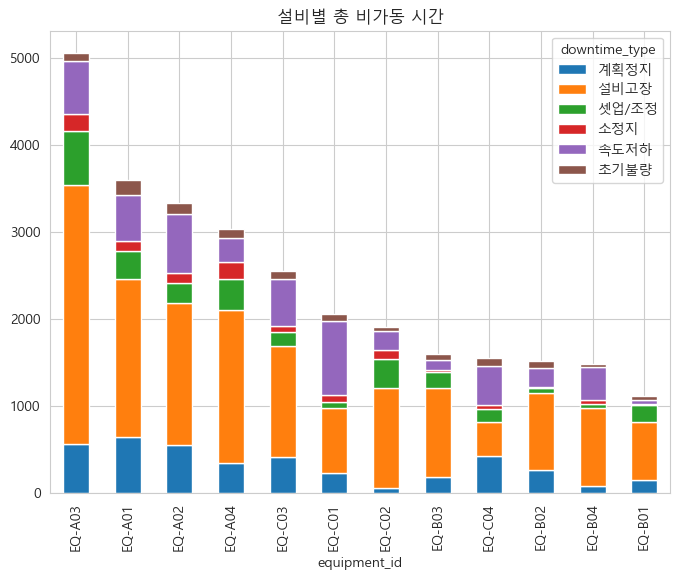

In [52]:
# 2. **스택 바 차트**로 시각화하세요
#    - 설비별 누적 막대그래프
#    - 각 유형별 색상 구분
eq_dttype_pivot.iloc[:, :-1].plot(kind='bar', figsize=(8, 6), stacked=True)

plt.title('설비별 총 비가동 시간')
plt.show()

In [53]:
# 3. 비가동 시간이 가장 긴 설비 Top 3는? 주로 어떤 유형인가?
eq_dttype_pivot.head(3).iloc[:, :-1].idxmax(axis=1)

equipment_id
EQ-A03    설비고장
EQ-A01    설비고장
EQ-A02    설비고장
dtype: object

In [54]:
# 4. 비가동 기록이 없는 설비가 있는지 확인하세요 (equipment 테이블과 left join)
eq_downtime = pd.merge(equipment, downtime['equipment_id'].value_counts(), on='equipment_id', how='left')
eq_downtime[eq_downtime['count'].isna()]

,equipment_id,equipment_name,line,equipment_type,manufacturer,install_date,rated_capacity_per_hour,count
12,EQ-D01,CNC선반-D1(신규),D라인(신규),CNC선반,화낙,2024-06-01,140,NaN


### 문제 4-3: 설비고장 원인 Top 분석 (5점)

설비고장은 비가동의 가장 큰 원인입니다. 고장 원인을 세부적으로 분석합니다.

1. `downtime_type == '설비고장'`인 데이터만 필터링
2. `cause`별 건수와 총 비가동 시간을 집계
3. 라인별로 고장 원인 분포가 다른지 **그룹화 막대 차트**로 비교
4. 월별 설비고장 건수 추이를 그리세요 (개선 효과 확인)

In [55]:
# 1. `downtime_type == '설비고장'`인 데이터만 필터링
failures = downtime[downtime['downtime_type'] == '설비고장'].copy()
failures

,downtime_id,date,equipment_id,shift,downtime_type,start_time,end_time,duration_min,cause,line
1,DT-00002,2024-01-02,EQ-A01,주간,설비고장,2024-01-02 09:24:00,2024-01-02 11:43:00,139.0,스핀들 이상,A라인
2,DT-00003,2024-01-02,EQ-A04,야간,설비고장,2024-01-02 00:45:00,2024-01-02 01:38:00,53.0,원인미상,A라인
5,DT-00006,2024-01-03,EQ-A02,야간,설비고장,2024-01-03 23:29:00,2024-01-04 01:22:00,113.0,스핀들 이상,A라인
7,DT-00008,2024-01-03,EQ-C02,야간,설비고장,2024-01-03 03:25:00,2024-01-03 06:04:00,159.0,센서 오작동,C라인
8,DT-00009,2024-01-03,EQ-C03,야간,설비고장,2024-01-03 03:29:00,2024-01-03 06:36:00,187.0,스핀들 이상,C라인
...,...,...,...,...,...,...,...,...,...,...
403,DT-00404,2024-06-19,EQ-A02,주간,설비고장,2024-06-19 11:31:00,2024-06-19 12:27:00,56.0,원인미상,A라인
406,DT-00407,2024-06-19,EQ-B03,야간,설비고장,2024-06-19 23:06:00,2024-06-20 02:38:00,212.0,전기 접촉 불량,B라인
408,DT-00409,2024-06-20,EQ-A04,주간,설비고장,2024-06-20 11:58:00,2024-06-20 15:48:00,230.0,스핀들 이상,A라인
411,DT-00412,2024-06-20,EQ-C02,야간,설비고장,2024-06-20 04:49:00,2024-06-20 06:07:00,78.0,원인미상,C라인


In [56]:
# 2. `cause`별 건수와 총 비가동 시간을 집계
failure_cause = failures.groupby('cause').agg({'downtime_id':'count',
                                               'duration_min':'sum'})
failure_cause.columns = ['건수', '총 비가동 시간']
failure_cause = failure_cause.sort_values('건수', ascending=False)
failure_cause

,건수,총 비가동 시간
cause,,
스핀들 이상,24,3132.017544
센서 오작동,19,2658.000000
모터 과열,19,2549.000000
베어링 마모,18,2440.000000
유압 누유,15,2050.000000
전기 접촉 불량,13,1597.000000
원인미상,7,756.000000


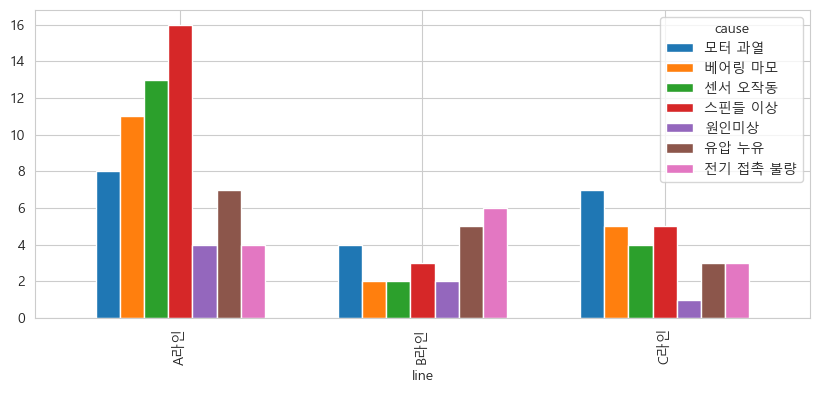

In [58]:
# 3. 라인별로 고장 원인 분포가 다른지 **그룹화 막대 차트**로 비교
line_fail_cause = failures.groupby(['line', 'cause']).size().unstack()
line_fail_cause.plot(kind='bar', figsize=(10, 4), width=0.7)
plt.show()

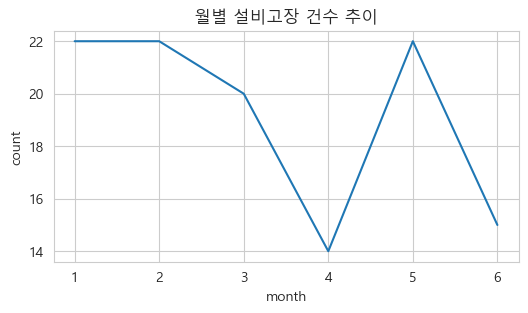

In [309]:
# 4. 월별 설비고장 건수 추이를 그리세요 (개선 효과 확인)
failures['month'] = failures['date'].dt.month
failures['month'].value_counts().sort_index().plot(title='월별 설비고장 건수 추이', ylabel='count', figsize=(6, 3))
plt.show()

---
## Part 5: 경영진 보고용 대시보드 (15점)

지금까지 분석한 내용을 **한 페이지 대시보드**로 정리합니다.  
경영진은 숫자보다 **시각적 요약**을 선호합니다.

> **현업 포인트**: 대시보드는 '예쁘게' 만드는 것이 아니라  
> '의사결정에 필요한 정보'를 빠르게 전달하는 것이 목표입니다.

### 문제 5-1: 종합 대시보드 (15점)

`plt.subplot()` 또는 `fig.add_subplot()`을 사용하여 **2행 3열 (6개 패널)** 대시보드를 만드세요.  
Figure 크기: (20, 12)

**패널 구성:**

| 위치 | 차트 | 내용 |
|------|------|------|
| (1,1) | 라인 차트 | 월별 OEE 추이 (라인별, 3월 개선 활동 표시) |
| (1,2) | 수평 바 차트 | 설비별 OEE 랭킹 (색상으로 등급 표시) |
| (1,3) | 히트맵 | 라인 × 월 OEE 매트릭스 |
| (2,1) | 파이 차트 | 비가동 유형별 비율 |
| (2,2) | 그룹 바 차트 | 교대조별 OEE 3요소 비교 |
| (2,3) | 박스플롯 | 라인별 불량률 분포 |

**스타일 요구사항:**
- 전체 제목: '한국정밀산업(주) 생산 효율 대시보드 (2024년 상반기)'
- 각 패널에 소제목 포함
- `plt.tight_layout()` 적용
- 필요시 OEE 등급 색상 기준: 85% 이상(녹색), 70~85%(노란색), 70% 미만(빨간색)

In [97]:
# 여기에 코드 작성


---
## 분석 결론 작성

분석 결과를 바탕으로, 아래 항목에 대해 **마크다운 셀에 직접** 작성하세요.

1. **현재 공장 OEE 수준**: World Class 기준 대비 현재 위치는?
2. **OEE를 끌어내리는 주요 요인**: 가동률/성능률/양품률 중 어느 것이 가장 문제인가?
3. **개선 활동 효과**: 3월 이후 실제로 OEE가 개선되었는가? 얼마나?
4. **라인별 차이**: A/B/C 라인 간 차이의 원인은?
5. **우선 개선 대상**: 가장 먼저 개선해야 할 설비 또는 로스 유형은?
6. **구체적 개선 제안**: 데이터에 근거한 3가지 이상의 개선 방안

### 분석 결론 (여기에 작성)

1. **현재 공장 OEE 수준**: 

2. **OEE를 끌어내리는 주요 요인**: 

3. **개선 활동 효과**: 

4. **라인별 차이**: 

5. **우선 개선 대상**: 

6. **구체적 개선 제안**: 


---
## 수고하셨습니다!

### 학습 체크리스트
- [ ] 현장 데이터 결측치 확인 및 전처리
- [ ] IQR 기반 이상치 탐지
- [ ] 여러 테이블 Left Join 결합
- [ ] OEE 3요소(가동률·성능률·양품률) 직접 계산
- [ ] 설비별·라인별·월별 OEE 집계 및 비교
- [ ] 개선 전/후 효과 검증 (t-test)
- [ ] Six Big Losses 파레토 분석
- [ ] 이중 y축 차트, 히트맵, 파이 차트 등 다양한 시각화
- [ ] 6패널 종합 대시보드 구성
- [ ] 데이터 기반 개선 제안 도출